In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn import model_selection


from sklearn.model_selection import StratifiedKFold

In [12]:
df = pd.read_csv('/home/chris/Documents/Datasets/creditcard.csv')

In [13]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["Class"]):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

train_set = train_set.reset_index(drop = True)
credit_card = train_set.copy()

splitcv = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=43)
for train_index, cv_index in splitcv.split(credit_card, credit_card["Class"]):
    train60_set = credit_card.loc[train_index]
    cv_set = credit_card.loc[cv_index]
    
train60_set = train60_set.reset_index(drop = True)
cv_set = cv_set.reset_index(drop = True)
credit_card60 = train60_set.copy()
credit_card_cv = cv_set.copy()

In [14]:
m,n = credit_card.shape
X_train = credit_card.iloc[:,0:(n-1)]
y_train = credit_card.iloc[:,n-1]

data = X_train
scaler = StandardScaler()
scaler.fit(data)
X_train_scaled = scaler.transform(data)

In [15]:
m,n = credit_card60.shape
X_train60 = credit_card60.iloc[:,0:(n-1)]
y_train60 = credit_card60.iloc[:,n-1]
X_cv = credit_card_cv.iloc[:,0:(n-1)]
y_cv = credit_card_cv.iloc[:,n-1]

data = X_train60
scaler = StandardScaler()
scaler.fit(data)
X_train60_scaled = scaler.transform(data)

data = X_cv
scaler = StandardScaler()
scaler.fit(data)
X_cv_scaled = scaler.transform(data)

In [7]:
X_train60_cnn_resampled = np.loadtxt("/home/chris/Documents/ml/credit-card-fraud/cnntrain60.csv",delimiter=",")
y_train60_cnn_resampled = np.loadtxt("/home/chris/Documents/ml/credit-card-fraud/cnnlabel60.csv",delimiter=",")

In [8]:
X_train60_cnn_resampled.shape, y_train60_cnn_resampled.shape

((1150, 30), (1150,))

In [10]:
X_train60_cnn_resampled[0]

array([-0.11832264, -0.23782891,  0.09282648, -0.15499859, -0.68273855,
        1.34318681,  1.11327093,  0.83359515,  0.03380977,  0.35209188,
        0.43018706,  1.45771726,  1.10283356,  0.20637267, -0.25558285,
       -0.24237139, -1.54096944,  0.21038567, -2.59976624, -1.41754509,
        0.02023391, -0.28251622,  0.38805645,  0.69216932, -3.03169737,
       -1.70738748,  0.50788651,  0.02435773, -0.8377755 , -0.20139296])

In [11]:
import collections

collections.Counter(y_train60_cnn_resampled)

Counter({0.0: 855, 1.0: 295})

In [17]:
from imblearn.over_sampling import SMOTE, ADASYN
X_60SMOTEresampled, y_60SMOTEresampled = SMOTE(random_state=42).fit_sample(X_train60_scaled, y_train60)

In [18]:
KNN = KNeighborsClassifier(n_neighbors=8, p=1)
KNN.fit(X_train60_cnn_resampled,y_train60_cnn_resampled)

lgregclf = LogisticRegression(C = 10)
lgregclf.fit(X_60SMOTEresampled,y_60SMOTEresampled)

ldaclf = LinearDiscriminantAnalysis()
ldaclf.fit(X_train60_scaled,y_train60)


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [19]:
y_cv_pred_probKNN = KNN.predict_proba(X_cv_scaled)[:,1]
y_cv_pred_probLR = lgregclf.predict_proba(X_cv_scaled)[:,1]
y_cv_pred_probLDA = ldaclf.predict_proba(X_cv_scaled)[:,1]


In [20]:
y_cv_pred_prob = (y_cv_pred_probKNN + y_cv_pred_probLDA + y_cv_pred_probLR) / 3

In [23]:
y_cv_pred_prob[0], y_cv_pred_probKNN[0], y_cv_pred_probLDA[0], y_cv_pred_probLR[0]

(0.0013620205554544372, 0.0, 3.6612940922649575e-152, 0.004086061666363312)

0.8484841232375151


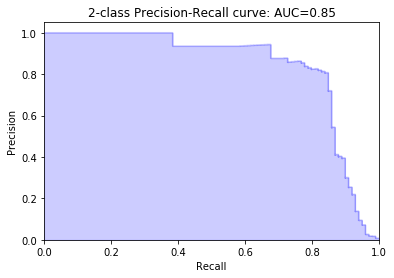

In [24]:
precision, recall, _ = precision_recall_curve(y_cv, y_cv_pred_prob)
area_under_curve = auc(recall,precision)


plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
          area_under_curve))
print(area_under_curve)

In [25]:
X_train60_cnn_resampled_no_time = X_train60_cnn_resampled[:,1:(n-1)]
X_60SMOTEresampled_no_time = X_60SMOTEresampled[:,1:(n-1)]
X_train60_scaled_no_time = X_train60_scaled[:,1:(n-1)]
X_cv_scaled_no_time = X_cv_scaled[:,1:(n-1)]

In [26]:
KNN = KNeighborsClassifier(n_neighbors=8, p=1)
KNN.fit(X_train60_cnn_resampled_no_time,y_train60_cnn_resampled)

lgregclf = LogisticRegression(C = 10)
lgregclf.fit(X_60SMOTEresampled_no_time,y_60SMOTEresampled)

ldaclf = LinearDiscriminantAnalysis()
ldaclf.fit(X_train60_scaled_no_time,y_train60)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [27]:
y_cv_pred_probKNN_no_time = KNN.predict_proba(X_cv_scaled_no_time)[:,1]
y_cv_pred_probLR_no_time = lgregclf.predict_proba(X_cv_scaled_no_time)[:,1]
y_cv_pred_probLDA_no_time = ldaclf.predict_proba(X_cv_scaled_no_time)[:,1]

In [28]:
y_cv_pred_prob_no_time = (y_cv_pred_probKNN + y_cv_pred_probLDA + y_cv_pred_probLR) / 3

0.8484841232375151


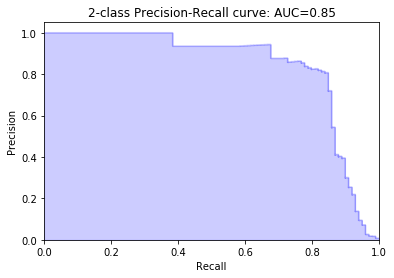

In [29]:
precision, recall, _ = precision_recall_curve(y_cv, y_cv_pred_prob_no_time)
area_under_curve = auc(recall,precision)


plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
          area_under_curve))
print(area_under_curve)